# Intraday IVS and Stock Return Predictability

#### Written in 2019/05/20, I-Fan Chiang

## Import modules

In [1]:
import pandas as pd
import numpy as np
from datetime import date
from math import exp, sqrt, log, fabs
import matplotlib.pyplot as plt
from itertools import repeat
from scipy.stats import shapiro, norm, kurtosis, skew
from statsmodels.graphics.gofplots import qqplot
from scipy.stats.mstats import winsorize
import statsmodels.formula.api as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns; sns.set()
import os
from tqdm import tqdm

## Path 

In [2]:
work_dir = os.getcwd()
Path_default_readcsv = os.path.join(work_dir,'Read_csv')
Path_default_trade = os.path.join(work_dir, 'trade_csv')
Path_output_csv = os.path.join(work_dir, 'Output_Result') 
Path_quote_noadj = os.path.join(work_dir, 'Output_Quote_noadj') 

## Set time period 

In [3]:
time_period =  pd.read_csv(os.path.join(Path_default_readcsv, 'period_Quote.csv'), header = None)
time_period.columns = ['Head', 'Tail', 'Middle']

x_axis_hour = [] #generate x axis
for s in time_period['Middle']:
    if s < 100000: #Avoid the disorder in ploting the x-axis
        if not int((s % 10000)/100) == 0:
            x_axis_hour.append('0' + str(int(s/10000)) +':' + str(int((s % 10000)/100)))
        else:
            x_axis_hour.append('0' + str(int(s/10000)) +':00')
    else:
        if not int((s % 10000)/100) == 0:
            x_axis_hour.append(str(int(s/10000)) +':' + str(int((s % 10000)/100)))
        else:
            x_axis_hour.append(str(int(s/10000)) +':00')
x_axis_hour = np.array(x_axis_hour)

list_year_and_month = []
list_year = []
start_year = 2007
end_year = 2017
start_month = 1
end_month = 12

for i in range(start_year, end_year + 1):
    list_year.append(str(i))
    for j in range(start_month, end_month + 1):
        if j < 10:
            list_year_and_month.append(str(i) + '0' + str(j))
        else:
            list_year_and_month.append(str(i) +str(j))

## Test for two period mu test

In [4]:
def twosampleZ(data1, data2):
    '''large sample size convert t-test to Z-test '''
    X1_bar = np.nanmean(data1)
    X2_bar = np.nanmean(data2)
    std1 = np.nanstd(data1)
    std2 = np.nanstd(data2)
    n1 = len(data1) - sum(np.isnan(data1)) #real value
    n2 = len(data1) - sum(np.isnan(data2))
    pooledSE = sqrt(std1**2/n1 + std2**2/n2)
    z = ((X1_bar - X2_bar))/pooledSE
    pval = 2*(1 - norm.cdf(abs(z))) #two-sided z test
    
    return round(z, 4), round(pval, 4)    

## Convert the result summary to df

In [5]:
def results_summary_to_df(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    tvals = results.tvalues
    rsquare = results.rsquared

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "tvals":tvals,
                               "R^2":rsquare
                                })

    #Reordering...
    results_df = results_df[["coeff","tvals","pvals", "R^2"]]
    return results_df

# Test the population mean of IVS between 2007 to 2017 (11 years X 14 T.P.)

### --------------------------------------------- Load IVS Data --------------------------------------------- 

In [6]:
# For trade
#df_IVS = pd.read_csv(os.path.join(Path_default_trade, 'df_overall_vs_trade.csv'), index_col = 0)
# For Quote with adj 
df_IVS = pd.read_csv(os.path.join(Path_output_csv, 'df_overall_vs.csv'), index_col = 0)
# For Quote without adj 
#df_IVS = pd.read_csv(os.path.join(Path_quote_noadj, 'df_overall_vs.csv'), index_col = 0)

In [7]:
list_stat = []
list_p = []
list_corrcoef = []
for i, hour in enumerate(x_axis_hour):
    list_stat.append([])
    list_p.append([])
    list_corrcoef.append([])
    for other_hour in x_axis_hour: 
        stat, p = twosampleZ(df_IVS[hour], df_IVS[other_hour])
        list_stat[i].append(stat)
        list_p[i].append(p)
        list_corrcoef[i].append(np.corrcoef(df_IVS[hour], df_IVS[other_hour])[0][1])

df_p = pd.DataFrame(list_p, columns = x_axis_hour)
df_p.index = x_axis_hour
df_stat = pd.DataFrame(list_stat, columns = x_axis_hour)
df_stat.index = x_axis_hour
df_corrcoef = pd.DataFrame(list_corrcoef, columns = x_axis_hour)
df_corrcoef.index = x_axis_hour

In [8]:
df_p

,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00
08:30,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
09:00,0.0,1.0000,0.0777,0.0890,0.0005,0.0002,0.0025,0.0010,0.0003,0.0005,0.0000,0.0000,0.0000,0.0000
09:30,0.0,0.0777,1.0000,0.9162,0.0975,0.0511,0.2217,0.1318,0.0616,0.0884,0.0157,0.0012,0.0000,0.0000
10:00,0.0,0.0890,0.9162,1.0000,0.0709,0.0351,0.1741,0.0990,0.0434,0.0644,0.0099,0.0006,0.0000,0.0000
10:30,0.0,0.0005,0.0975,0.0709,1.0000,0.7657,0.6623,0.8941,0.8058,0.9320,0.4287,0.0943,0.0002,0.0000
11:00,0.0,0.0002,0.0511,0.0351,0.7657,1.0000,0.4630,0.6690,0.9630,0.8371,0.6187,0.1655,0.0006,0.0000
11:30,0.0,0.0025,0.2217,0.1741,0.6623,0.4630,1.0000,0.7651,0.5005,0.6089,0.2226,0.0367,0.0000,0.0000
12:00,0.0,0.0010,0.1318,0.0990,0.8941,0.6690,0.7651,1.0000,0.7086,0.8302,0.3610,0.0746,0.0001,0.0000
12:30,0.0,0.0003,0.0616,0.0434,0.8058,0.9630,0.5005,0.7086,1.0000,0.8756,0.5933,0.1596,0.0006,0.0000
13:00,0.0,0.0005,0.0884,0.0644,0.9320,0.8371,0.6089,0.8302,0.8756,1.0000,0.4909,0.1202,0.0004,0.0000


## Winsorize -- eliminate the outlier 0.01 and 0.99

In [9]:
for time in x_axis_hour:
    df_IVS[time] = winsorize(df_IVS[time], limits=[0.005, 0.005])
df_IVS.head()

,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00
20070103,0.031879,-0.058003,-0.041286,-0.034553,-0.040357,-0.034968,-0.038967,-0.038427,-0.047495,-0.042016,-0.038457,-0.047091,-0.032863,-0.031471
20070104,-0.054210,-0.046212,-0.045649,-0.035937,-0.040882,-0.027540,-0.030557,-0.040982,-0.036969,-0.038966,-0.037579,-0.042770,-0.025064,NaN
20070105,NaN,-0.044182,-0.038050,-0.042730,-0.046763,-0.035898,-0.030660,-0.037769,-0.042890,-0.040030,-0.039458,-0.040984,-0.036894,-0.042845
20070108,-0.048923,-0.037558,-0.029837,-0.030703,-0.027825,-0.034985,-0.034789,-0.026594,-0.031202,-0.028978,-0.033051,-0.032585,-0.021402,NaN
20070109,0.058079,-0.031943,-0.028956,-0.035188,-0.031506,-0.037763,-0.035851,-0.032104,-0.028440,-0.027628,-0.031302,-0.023837,-0.030601,-0.027335


##  Discriptive statistic

In [10]:
whole_days = list(df_IVS.index)
'''Find the start loc and end loc for each year
    Them append the mean, std, nan value for each year'''
start_year = 2007
yit = [0,]
for i, day in enumerate(whole_days):
    if str(day)[:4] == str(start_year):
        pass
    else: 
        start_year = start_year + 1
        yit.append(i) 
        
yit.append(len(whole_days)) #include the last digit

# total length = 15; first = 1
df_aggre_nan = pd.DataFrame()
df_aggre_mean = pd.DataFrame()
df_aggre_std = pd.DataFrame()
for i in range(1, 12):
    init = yit[i-1]
    end = yit[i]
    df_year_vs = df_IVS[init:end]
    yearname = str(df_year_vs.index[0])[:4]
    df_mean = df_year_vs.mean()
    df_std = df_year_vs.std()
    df_nan = df_year_vs.isna().sum()
    
    df_aggre_mean = df_aggre_mean.append(pd.DataFrame(df_mean).T)
    df_aggre_std = df_aggre_std.append(pd.DataFrame(df_std).T)
    df_aggre_nan = df_aggre_nan.append(pd.DataFrame(df_nan).T)
    
df_aggre_nan.index = list_year
df_aggre_mean.index = list_year
df_aggre_std.index = list_year

In [11]:
df_aggre_mean

,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00
2007,-0.041168,-0.047638,-0.046715,-0.046998,-0.045968,-0.046535,-0.046197,-0.046382,-0.046712,-0.046336,-0.045559,-0.045875,-0.042384,-0.048953
2008,-0.042362,-0.046371,-0.048805,-0.050125,-0.050128,-0.048458,-0.049748,-0.051486,-0.051104,-0.050669,-0.051137,-0.049839,-0.048764,-0.044497
2009,-0.037045,-0.044989,-0.044511,-0.043516,-0.043087,-0.043216,-0.042806,-0.042252,-0.042933,-0.042580,-0.042718,-0.042152,-0.041441,-0.040019
2010,-0.023951,-0.042942,-0.042564,-0.042763,-0.040721,-0.039593,-0.041946,-0.041334,-0.040309,-0.040588,-0.040266,-0.040002,-0.038502,-0.035914
2011,-0.011370,-0.032452,-0.031148,-0.032107,-0.031951,-0.031862,-0.031970,-0.031476,-0.030877,-0.032640,-0.032188,-0.031748,-0.031148,-0.031243
2012,-0.014333,-0.033645,-0.031606,-0.031516,-0.030271,-0.030385,-0.031597,-0.030878,-0.030515,-0.031970,-0.031065,-0.030047,-0.031223,-0.029752
2013,-0.019468,-0.031388,-0.029939,-0.029677,-0.030381,-0.030054,-0.030770,-0.030435,-0.030423,-0.030787,-0.030233,-0.029627,-0.029958,-0.031771
2014,-0.007974,-0.028001,-0.025807,-0.025480,-0.024763,-0.024651,-0.023658,-0.023657,-0.023736,-0.024393,-0.025109,-0.024301,-0.024720,-0.019787
2015,-0.019334,-0.038393,-0.037952,-0.036622,-0.036150,-0.036340,-0.036612,-0.036983,-0.036756,-0.036422,-0.036459,-0.036691,-0.036481,-0.035578
2016,-0.027321,-0.038755,-0.034958,-0.037588,-0.035861,-0.035974,-0.036419,-0.036503,-0.036174,-0.036473,-0.036261,-0.036626,-0.036763,-0.034600


In [12]:
df_all_sum = np.sum(df_aggre_nan, axis = 0)/2654
df_all_sum

08:30    0.038056
09:00    0.090806
09:30    0.168425
10:00    0.199699
10:30    0.221176
11:00    0.244913
11:30    0.261115
12:00    0.276187
12:30    0.296910
13:00    0.312735
13:30    0.332705
14:00    0.348531
14:30    0.371515
15:00    0.460437
dtype: float64

## For testing the forward SPX_return

### Append SPX Return

In [13]:
'''For SPX_return_F ~ C(time_period) + DDEF + DTERM + SPX_return '''

Path_SP_data = os.path.join(Path_default_readcsv, 'SPX_PUTCALL.csv')
df_SP = pd.read_csv(Path_SP_data, index_col = 0)
list_SPXprice = [price for price in df_SP['SPX Price']]

list_SPXreturn = [np.nan,]
# Return = log(Pt+1/Pt)
for i in range(1, len(list_SPXprice)):
    list_SPXreturn.append(np.log(list_SPXprice[i]/list_SPXprice[i-1]))
df_SP['SPX_return'] = list_SPXreturn

### Calculated the Return Without Overnight Risk

In [14]:
df_SP_5min = pd.read_csv(os.path.join(Path_default_readcsv, 'SPXT_5min.csv'), index_col = 0)
df_SP_5min.head(5)

,t0830,t0835,t1500,Return_0830to1500,Return_0835to1500
20070103,1418.03,1422.14,1416.599976,-0.003903,-0.003903
20070104,1416.95,1413.40,1418.339966,0.003489,0.003489
20070105,1417.58,1413.97,1409.709961,-0.003017,-0.003017
20070108,1409.22,1408.19,1412.839966,0.003297,0.003297
20070109,1412.85,1414.17,1412.109985,-0.001458,-0.001458


In [15]:
def AppendSPXReturn(mode):
    '''Mode: choose whitch return we want to focus
        Output: The IVS data would append SPX price, returns_t, returns_t+1, returns_t+5, returns_t-1;  
    '''
    df_IVS['SPX price'] = df_IVS.index.map(df_SP['SPX Price'])
    if mode == 'Open': #close minus open
        df_IVS['SPX_return'] =  df_IVS.index.map(df_SP_5min['Return_0830to1500'])
        
    elif mode == 'After5min': #close minus 5min after open
        df_IVS['SPX_return'] =  df_IVS.index.map(df_SP_5min['Return_0835to1500'])
        
    elif mode == 'Original': #close minus last day close
        df_IVS['SPX_return'] =  df_IVS.index.map(df_SP['SPX_return'])
    
    df_IVS['SPX_return_Lag1'] = df_IVS['SPX_return'].shift(1) # t-1 Return 
    df_IVS['SPX_return_For1'] = df_IVS['SPX_return'].shift(-1) # t+1 Return 
    df_IVS['SPX_return_For5'] = df_IVS['SPX_return'].shift(-5) #t+5 Return 

In [16]:
AppendSPXReturn(mode = 'Original')
df_IVS.head(5)

,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,SPX price,SPX_return,SPX_return_Lag1,SPX_return_For1,SPX_return_For5
20070103,0.031879,-0.058003,-0.041286,-0.034553,-0.040357,-0.034968,-0.038967,-0.038427,-0.047495,-0.042016,-0.038457,-0.047091,-0.032863,-0.031471,1416.599976,-0.001199,NaN,0.001228,0.001938
20070104,-0.054210,-0.046212,-0.045649,-0.035937,-0.040882,-0.027540,-0.030557,-0.040982,-0.036969,-0.038966,-0.037579,-0.042770,-0.025064,NaN,1418.339966,0.001228,-0.001199,-0.006103,0.006320
20070105,NaN,-0.044182,-0.038050,-0.042730,-0.046763,-0.035898,-0.030660,-0.037769,-0.042890,-0.040030,-0.039458,-0.040984,-0.036894,-0.042845,1409.709961,-0.006103,0.001228,0.002218,0.004841
20070108,-0.048923,-0.037558,-0.029837,-0.030703,-0.027825,-0.034985,-0.034789,-0.026594,-0.031202,-0.028978,-0.033051,-0.032585,-0.021402,NaN,1412.839966,0.002218,-0.006103,-0.000517,0.000817
20070109,0.058079,-0.031943,-0.028956,-0.035188,-0.031506,-0.037763,-0.035851,-0.032104,-0.028440,-0.027628,-0.031302,-0.023837,-0.030601,-0.027335,1412.109985,-0.000517,0.002218,0.001938,-0.000894


### Append Special Date

In [17]:
Special_date = pd.read_csv(os.path.join(Path_default_readcsv, 'Special_date.csv'),  index_col = 0)
# Append FOMC and Business_cycle
df_IVS['FOMC'] =  df_IVS.index.map(Special_date['FOMC'])
df_IVS['Business_cycle'] =  df_IVS.index.map(Special_date['Business_cycle'])
df_IVS['BWPLUS'] = df_IVS.index.map(Special_date['BWPLUS'])
df_IVS['UOMPLUS'] = df_IVS.index.map(Special_date['UOMPLUS'])
df_IVS['VOLPLUS'] = df_IVS.index.map(Special_date['VOLPLUS'])

### Append DDEF(The AAA - Baa Bond Yeild) and DTerm (The 10 year - 1 month Bond Yeild) 

In [18]:
Path_DEF_data = os.path.join(work_dir, 'BondYield', 'DDEF.csv')
Path_TERM_data = os.path.join(work_dir, 'BondYield', 'DTERM.csv')
df_DEF = pd.read_csv(Path_DEF_data, index_col = 0)
df_TERM = pd.read_csv(Path_TERM_data, index_col = 0)

df_IVS['DDEF'] =  df_IVS.index.map(df_DEF['DDEF'])
df_IVS['DTERM'] =  df_IVS.index.map(df_TERM['DTERM(10year-1month)'])

In [19]:
df_IVS.head(5)

,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,...,SPX_return_Lag1,SPX_return_For1,SPX_return_For5,FOMC,Business_cycle,BWPLUS,UOMPLUS,VOLPLUS,DDEF,DTERM
20070103,0.031879,-0.058003,-0.041286,-0.034553,-0.040357,-0.034968,-0.038967,-0.038427,-0.047495,-0.042016,...,NaN,0.001228,0.001938,Release,Expansion,1,0,0,0.96,-0.38
20070104,-0.054210,-0.046212,-0.045649,-0.035937,-0.040882,-0.027540,-0.030557,-0.040982,-0.036969,-0.038966,...,-0.001199,-0.006103,0.006320,NonRelease,Expansion,1,0,0,0.96,-0.42
20070105,NaN,-0.044182,-0.038050,-0.042730,-0.046763,-0.035898,-0.030660,-0.037769,-0.042890,-0.040030,...,0.001228,0.002218,0.004841,NonRelease,Expansion,1,0,0,0.96,-0.40
20070108,-0.048923,-0.037558,-0.029837,-0.030703,-0.027825,-0.034985,-0.034789,-0.026594,-0.031202,-0.028978,...,-0.006103,-0.000517,0.000817,NonRelease,Expansion,1,0,0,0.96,-0.42
20070109,0.058079,-0.031943,-0.028956,-0.035188,-0.031506,-0.037763,-0.035851,-0.032104,-0.028440,-0.027628,...,0.002218,0.001938,-0.000894,NonRelease,Expansion,1,0,0,0.96,-0.42


In [20]:
df_copy = df_IVS.copy()
columns_name = ['t0830', 't0900', 't0930', 't1000', 
                't1030', 't1100', 't1130', 't1200', 
                't1230', 't1300', 't1330', 't1400', 
                't1430', 't1500', 'SPX_price', 'SPX_return',
                'SPX_return_Lag1', 'SPX_return_For1', 'SPX_return_For5','FOMC', 'Business_cycle', 'BWDummy', 'UOMDummy', 'VOLDummy', 'DDEF', 'DTERM']

df_copy.columns = columns_name
df_copy.to_csv(os.path.join(Path_output_csv, 'df_IVS_SPX.csv'))

In [21]:
df_copy.head(5)

,t0830,t0900,t0930,t1000,t1030,t1100,t1130,t1200,t1230,t1300,...,SPX_return_Lag1,SPX_return_For1,SPX_return_For5,FOMC,Business_cycle,BWDummy,UOMDummy,VOLDummy,DDEF,DTERM
20070103,0.031879,-0.058003,-0.041286,-0.034553,-0.040357,-0.034968,-0.038967,-0.038427,-0.047495,-0.042016,...,NaN,0.001228,0.001938,Release,Expansion,1,0,0,0.96,-0.38
20070104,-0.054210,-0.046212,-0.045649,-0.035937,-0.040882,-0.027540,-0.030557,-0.040982,-0.036969,-0.038966,...,-0.001199,-0.006103,0.006320,NonRelease,Expansion,1,0,0,0.96,-0.42
20070105,NaN,-0.044182,-0.038050,-0.042730,-0.046763,-0.035898,-0.030660,-0.037769,-0.042890,-0.040030,...,0.001228,0.002218,0.004841,NonRelease,Expansion,1,0,0,0.96,-0.40
20070108,-0.048923,-0.037558,-0.029837,-0.030703,-0.027825,-0.034985,-0.034789,-0.026594,-0.031202,-0.028978,...,-0.006103,-0.000517,0.000817,NonRelease,Expansion,1,0,0,0.96,-0.42
20070109,0.058079,-0.031943,-0.028956,-0.035188,-0.031506,-0.037763,-0.035851,-0.032104,-0.028440,-0.027628,...,0.002218,0.001938,-0.000894,NonRelease,Expansion,1,0,0,0.96,-0.42


# ========================================================
#                        Organized the SPX Half-Hour Return Data                            
# ========================================================

In [22]:
df_halfHourSPXPrice = pd.read_csv(os.path.join(Path_default_readcsv, 'Half_hour_SPX.csv'), index_col = 0)
# df_halfHourSPXPrice = pd.read_csv(os.path.join(Path_default_readcsv, 'Half_hour_SPX_fake.csv'), index_col = 0)
columns_name1 =  ['t0830', 't0900', 't0930', 't1000', 
                't1030', 't1100', 't1130', 't1200', 
                't1230', 't1300', 't1330', 't1400', 
                't1430', 't1500']
df_halfHourSPXPrice.columns = columns_name1
index_list = list(df_halfHourSPXPrice.index.values)
df_halfHourSPXPrice.head(5)

,t0830,t0900,t0930,t1000,t1030,t1100,t1130,t1200,t1230,t1300,t1330,t1400,t1430,t1500
20070103,1418.03,1423.85,1429.18,1427.56,1427.63,1427.93,1425.62,1427.09,1423.60,1422.36,1416.61,1408.23,1413.11,1416.03
20070104,1416.95,1413.63,1409.37,1415.66,1415.71,1416.56,1415.61,1415.91,1413.56,1414.15,1414.20,1418.58,1419.30,1419.00
20070105,1417.58,1410.11,1412.93,1412.74,1407.79,1407.84,1409.29,1409.65,1410.21,1410.17,1408.56,1409.09,1409.74,1411.15
20070108,1409.22,1407.31,1405.71,1407.82,1408.28,1409.12,1408.30,1408.64,1407.88,1412.06,1413.60,1411.50,1414.27,1413.42
20070109,1412.85,1413.11,1414.75,1413.33,1410.26,1406.72,1405.67,1407.76,1408.57,1409.98,1411.01,1412.21,1412.75,1413.10


In [23]:
df_halfHourSPXReturn = pd.DataFrame()
for i, col in enumerate(columns_name1):
    
    list_SPXpriceCur = [price for price in df_halfHourSPXPrice[columns_name1[i]]]
    if col != 't0830':
        list_SPXpriceLast = [price for price in df_halfHourSPXPrice[columns_name1[i-1]]]
    else:
        list_SPXpriceLast = [price for price in df_halfHourSPXPrice[columns_name1[i-1]]]
        list_SPXpriceLast.insert(0, 1418.30) # 2016/12/29 the SPX price is 1418.30
        
    # Return = log(Pt+1/Pt)
    list_SPXreturn = []
    for j in range(len(list_SPXpriceCur)):
        if(list_SPXpriceCur[j] > 0 and list_SPXpriceLast[j] > 0):
            list_SPXreturn.append(np.log(list_SPXpriceCur[j]/list_SPXpriceLast[j]))
        else:
            list_SPXreturn.append(np.nan)
    df_halfHourSPXReturn[col] = list_SPXreturn

In [24]:
df_halfHourSPXReturn.index = index_list
df_halfHourSPXReturn.to_csv(os.path.join(Path_default_readcsv, 'Half_hour_SPX_Return.csv'))
df_halfHourSPXReturn.head(5)

,t0830,t0900,t0930,t1000,t1030,t1100,t1130,t1200,t1230,t1300,t1330,t1400,t1430,t1500
20070103,-0.000190,0.004096,0.003736,-0.001134,0.000049,0.000210,-0.001619,0.001031,-0.002449,-0.000871,-0.004051,-0.005933,0.003459,0.002064
20070104,0.000649,-0.002346,-0.003018,0.004453,0.000035,0.000600,-0.000671,0.000212,-0.001661,0.000417,0.000035,0.003092,0.000507,-0.000211
20070105,-0.001001,-0.005283,0.001998,-0.000134,-0.003510,0.000036,0.001029,0.000255,0.000397,-0.000028,-0.001142,0.000376,0.000461,0.001000
20070108,-0.001369,-0.001356,-0.001138,0.001500,0.000327,0.000596,-0.000582,0.000241,-0.000540,0.002965,0.001090,-0.001487,0.001961,-0.000601
20070109,-0.000403,0.000184,0.001160,-0.001004,-0.002175,-0.002513,-0.000747,0.001486,0.000575,0.001001,0.000730,0.000850,0.000382,0.000248


### Cumulated the forward Half-hour time period  returns

In [25]:
def hourFoward2df(HourFoward, start_loc = 0):
    '''HourFoward: how many half-Hour period returns need to cumulated
        default is 't0830'
    '''
    cumReturn = 0
    df_cumReturn = pd.DataFrame()
    loc = start_loc + 1
    for i in range(HourFoward): 
        cumReturn += df_halfHourSPXReturn[columns_name1[loc]]
        loc += 1
    df_cumReturn['CumReturn'] = cumReturn
    df_cumReturn.index = index_list
    return df_cumReturn

In [26]:
def hourFowardNonCum2df(HourFoward, start_loc = 0):
    '''HourFoward: represents the hour forward returns
        default is 't0830'
    '''
    cumReturn = 0
    df_cumReturn = pd.DataFrame()
    loc = start_loc + 1
    for i in range(HourFoward): 
        cumReturn = df_halfHourSPXReturn[columns_name1[loc]]
        loc += 1
    df_cumReturn['CumReturn'] = cumReturn
    df_cumReturn.index = index_list
    return df_cumReturn

In [27]:
df_CumReturn = hourFowardNonCum2df(1, start_loc = 0)
df_CumReturn.head(5)

,CumReturn
20070103,0.004096
20070104,-0.002346
20070105,-0.005283
20070108,-0.001356
20070109,0.000184


## Regression on Assigned Time period

In [32]:
def test_SPX_return(timeInput, df_input, Dummy = False,  Forward = 0, HalfHourFoward = 0):
    
    ''' Input the time period and check the test statisitics, e.g.
        @time_input = 't1200', it means we'd like to test 12:00; 
        
        @read_data = the df of csv; 
        
        @Forward = 1, it means we'd like to test t+1 SPX return regress on other independent variable; 
            it could only be [0, 1, 5]
            
        @HalfHourFoward = 2, it means we'd like to test 2 period return ahead of the current period. 
            it could only be 1 to 13
            
        @Dummy: FOMC, Business_cycle, BWDummy, UOMDummy, VOLDummy
    '''
    
    #Input Y
    OptionY = ['SPX_return', 'SPX_return_For1', 'SPX_return_For5']
    OptionX1 = ['SPX_return_Lag1', 'SPX_return', 'SPX_return']
    columns_name1 =  ['t0830', 't0900', 't0930', 't1000', 't1030', 't1100', 't1130', 't1200', 
                    't1230', 't1300', 't1330', 't1400', 't1430', 't1500']   
    
    if Forward == 0 and HalfHourFoward == 0:
        y = OptionY[0]
        x1 = OptionX1[0]
    elif Forward == 1:
        y = OptionY[1]
        x1 = OptionX1[1]
    elif Forward == 5:
        y = OptionY[2]
        x1 = OptionX1[2]
    
    if HalfHourFoward != 0 and timeInput != 't1500':
        start_loc = columns_name1.index(timeInput)
        df_CumReturn = hourFoward2df(HalfHourFoward, start_loc = start_loc)
        #df_CumReturn = hourFowardNonCum2df(HalfHourFoward, start_loc = start_loc)
        df_input['HalfHourFoward'] = df_input.index.map(df_CumReturn['CumReturn'])
        df_input['HalfHourFoward'] = df_input['HalfHourFoward'].shift(-1*Forward)
        y = 'HalfHourFoward'
        x1 = OptionX1[0]
        
    df = df_input
    # split the sample into Plus and Minus, refer to Atilgan, Bali (2015)
    if Dummy != False:
        plusList = []
        minusList = []
        for ele, vs in zip(df[Dummy], df[timeInput]):
            if ele == 1 or ele == 'Contraction':
                plusList.append(vs)
                minusList.append(0)
            else: 
                plusList.append(0)
                minusList.append(vs)
        df['DummyPlus'] = plusList
        df['DummyMinus'] = minusList
    stat, p = twosampleZ(df['DummyPlus'], df['DummyMinus'])
    
    # regression form
    if Dummy != False:
        results = sm.ols(formula = '{Y} ~ {P} + {M} + DDEF + DTERM '.format(Y = y, P = 'DummyPlus', M = 'DummyMinus'), data = df, missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':1})
    else:
        results = sm.ols(formula = '{Y} ~ {T} + DDEF + DTERM '.format(Y = y, T = timeInput), data = df, missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':1})
        #results = sm.ols(formula = '{Y} ~ {T} + DDEF + DTERM + C({Dummy}) + {T}*C({Dummy})'.format(Y = y, T = timeInput, Dummy = Dummy), data = df, missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':1})
    print(results.summary())
    print("stat: ", stat)
    print("p: ", p)
    df_res = results_summary_to_df(results)
    return df_res

In [101]:
timeInput = 't1500' 
forward = 0
HHF = 0

df_res = test_SPX_return(timeInput = timeInput, Dummy = "Business_cycle", df_input = df_copy, Forward = forward, HalfHourFoward = HHF)
name = timeInput + '_HHF_' + str(HHF) + '.csv'
#name = timeInput + '.csv'
# df_res.to_csv(os.path.join(work_dir,'df_res', 'regression5', name))


                            OLS Regression Results                            
Dep. Variable:             SPX_return   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.433
Date:                Sun, 14 Jul 2019   Prob (F-statistic):              0.221
Time:                        01:30:24   Log-Likelihood:                 4468.4
No. Observations:                1424   AIC:                            -8927.
Df Residuals:                    1419   BIC:                            -8901.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0021      0.002      1.193      0.2

In [30]:
def plot_IVS(df, freq = 10, interval = 't0830'):
    from_index = 0
    date_length = len(df)
    date_int = int(date_length//freq)
    indexes = list(range(0, date_length, date_int))
    dateListInt = list(df.index.values)
    dateListStr = list(str(date) for date in list(df.index.values))
    
    IVS = []
    dateList = []
    for ind in indexes:
        IVS.append(float(df[interval][dateListInt[from_index + ind]]))
        dateList.append(dateListStr[from_index + ind])

    plt.figure(figsize=(20,6))
    plt.style.use('ggplot')
    plt.plot(dateList, IVS, '-o', label = 'IVS')
    plt.xticks(fontsize=8, rotation=45)
    plt.title(interval)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Implied Volatility Spread', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

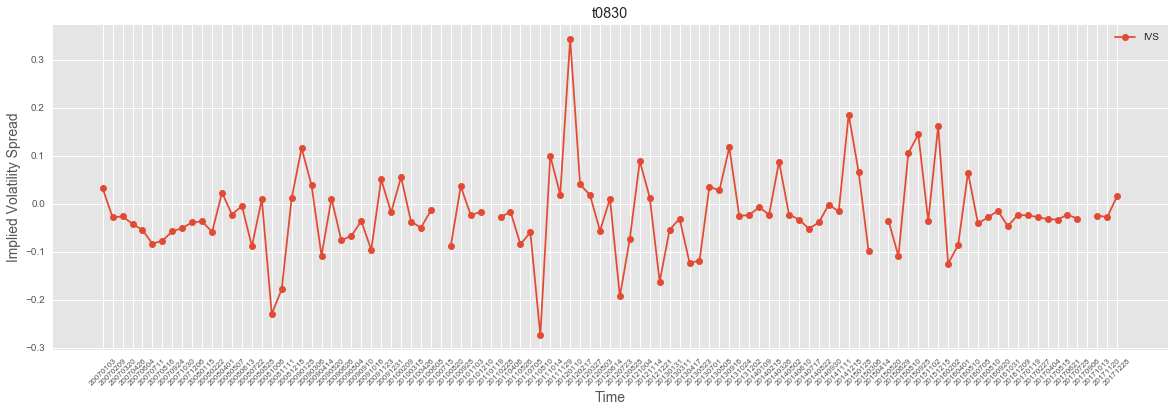

In [31]:
plot_IVS(df_copy, freq = 100, interval = 't0830')